# Transfer Learning with Resnet18 in Pytorch

In this notebook I want to download Resnet18 and use it to perform transfer learning. I'm going to use the same hyperparameters as the authors of the paper, just to be able to reproduce the model results.

I'll use 128 x 128 images.

# Import Libraries

In [1]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time

In [2]:
# installed new module to show model summary
from torchinfo import summary

## Import Custom Modules

In [3]:
import sys 
sys.path

['/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python312.zip',
 '/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python3.12',
 '/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python3.12/lib-dynload',
 '',
 '/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python3.12/site-packages']

In [4]:
sys.path.append('..')

In [5]:
sys.path

['/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python312.zip',
 '/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python3.12',
 '/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python3.12/lib-dynload',
 '',
 '/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python3.12/site-packages',
 '..']

# Define Hyperparameters

Here we're using the same hyperparameters as the publication minus the image size (in the paper they use 128 x 128 images)

In [6]:
BATCH_SIZE = 64
LEARNING_RATE = 0.01
N_EPOCHS = 50
N_CLASSES = 2

# to be used for height and width of final image
IMAGE_SIZE = 128

In [47]:
# Set manual seed for repeatability
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)

# Prepare Data

## Define Custom Class and Paths

In [7]:
# Import Custom Dataset Class
from src.data.create_dataset import CustomFireImagesDataset

Define paths to dataset and annotations file

In [8]:
path_to_dataset = '../data_preprocessing/02_forest_fire_dataset/'
annotations_file_test = 'labels_02_test_dataset_prep.csv'
annotations_file_train = 'labels_02_train_dataset_prep.csv'

In [9]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import v2

## Load Dataset and obtain Statistics

First define the transformations to get statistics

In [10]:
# Convert uint8 to float and divide by 255. 
# This is the equivalent of ToTensor() when used on a PIL image

curr_transf = transforms.Compose([transforms.v2.ToDtype(torch.float),
                                  transforms.Normalize([0,0,0],[255,255,255]),
                                  transforms.Resize(size=(IMAGE_SIZE,IMAGE_SIZE))
                                 ])

In [11]:
train_dataset =  CustomFireImagesDataset(annotations_file_train, path_to_dataset,
                                         transform = curr_transf
                                        )

In [12]:
len(train_dataset)

1520

In [13]:
from src.data.dataset_properties import dataset_stat_prop

In [14]:
mean,std = dataset_stat_prop(train_dataset)

In [15]:
print('Mean\t',mean)
print('STD\t',std)

Mean	 tensor([0.4241, 0.3553, 0.2787])
STD	 tensor([0.2747, 0.2403, 0.2618])


We'll use these values later on to normalize the inputs for training

## Define Train and Test Data

In [16]:
# similar to before, but added an additional normalization
# according to the statistics we calculated

curr_transf = transforms.Compose([transforms.v2.ToDtype(torch.float),
                                  transforms.Normalize([0,0,0],[255,255,255]),
                                  transforms.Resize(size=(IMAGE_SIZE,IMAGE_SIZE)),
                                  transforms.Normalize(mean,std)
                                 ])

In [17]:
# First, create Datasets for Training and Testing
train_dataset =  CustomFireImagesDataset(annotations_file_train, path_to_dataset,
                                         transform = curr_transf
                                        )

test_dataset = CustomFireImagesDataset(annotations_file_test, path_to_dataset,
                                       transform = curr_transf
                                      )

img_classes = ('non-fire','fire')

In [18]:
# Next, create the DataLoaders
# We'll be shuffling both datasets

train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE,
                              shuffle = True, num_workers = 2)

test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE,
                             shuffle = True, num_workers = 2 )

In [19]:
len(train_dataset)

1520

In [20]:
len(test_dataset)

380

## Plot Images from Sample Batch

In [ ]:
from src.visualization.plot_images import display_image_batch

In [ ]:
display_image_batch(train_dataloader,1,img_classes)

Note in a future implementation we need to adjust the figure size, as well as the labelling.

# Prepare Model (Resnet18)
Here we're downloading VGG19 with the default weights used for the ImageNet classification task. We'll modify the last layer to perform transfer learning.

## Download Model

In [34]:
resnet18 = models.resnet18(weights = 'DEFAULT')

In [35]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

We can see that the last layer has 512 inputs and 1000 outputs. This last number corresponds to the 1000 classes that the ImageNet problem originally required.

## Freeze Model Parameters

First freeze the model parameters, to avoid training them.

In [36]:
for param in resnet18.parameters():
    param.requires_grad = False

## Modify Final Layers

Next we modfify the last layer to do transfer learning:
- The number of inputs is still 512
- The number of outputs now equals the number of classes (2)

In [37]:
resnet18.fc

Linear(in_features=512, out_features=1000, bias=True)

In [38]:
resnet18.fc = nn.Linear(in_features = 512, out_features = N_CLASSES, bias = True)

In [39]:
#check all changes were effected
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Important Note
Please note that we're choosing to have the model output the predicted logits (as opposed to having the hard or soft probabilities)

## Model Summary

In [40]:
summary(resnet18,(BATCH_SIZE,3,128,128))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [64, 2]                   --
├─Conv2d: 1-1                            [64, 64, 64, 64]          (9,408)
├─BatchNorm2d: 1-2                       [64, 64, 64, 64]          (128)
├─ReLU: 1-3                              [64, 64, 64, 64]          --
├─MaxPool2d: 1-4                         [64, 64, 32, 32]          --
├─Sequential: 1-5                        [64, 64, 32, 32]          --
│    └─BasicBlock: 2-1                   [64, 64, 32, 32]          --
│    │    └─Conv2d: 3-1                  [64, 64, 32, 32]          (36,864)
│    │    └─BatchNorm2d: 3-2             [64, 64, 32, 32]          (128)
│    │    └─ReLU: 3-3                    [64, 64, 32, 32]          --
│    │    └─Conv2d: 3-4                  [64, 64, 32, 32]          (36,864)
│    │    └─BatchNorm2d: 3-5             [64, 64, 32, 32]          (128)
│    │    └─ReLU: 3-6                    [64, 64, 32, 32]  

# Define Optimizer and Loss Function

We'll use Adam optimizer.

In [41]:
optimizer = torch.optim.Adam(resnet18.parameters(), lr = 0.001)

For loss function we'll use the Cross Entropy loss

In [42]:
loss_function = nn.CrossEntropyLoss()

# Define Training and Validation Loop

Here we're defining the function that's going to abstract the training and validation loops, for a given set of parameters
- model
- loss function
- optimizer
- number of epochs
- train and validation dataloaders

The outputs include
- the model after training
- a dictionary with the losses and accuracies for training and validation

In [31]:
import torch
import time
from datetime import datetime

def train_and_validate(model,loss_function,optimizer,N_EPOCHS,train_dataloader,val_dataloader):
    """Function to run training and validation loops for a given model
    
    Parameters
    ----------
    model : class
        Model to be trained
    loss_function : class
        Instance of a loss function
    optimizer : class
        Instance of optimizer to be used
    N_EPOCHS : integer
        Number of epochs to be used for training
    train_dataloader : dataloader
        Training set dataloader
    val_dataloader : dataloader
        Validation set dataloader
    
    Returns
    -------
    tuple
        model after training
        history dictionary containing train loss, train accuracy, validation loss and validation accuracy
    """
    assert isinstance(N_EPOCHS,int),'N_EPOCHS must be an integer'
    assert (N_EPOCHS >= 0),'N_EPOCHS must be positive'

    # dictionary to accumulate losses and accuracies
    history = {
        'train_losses':[],'train_accuracy':[],
        'validation_losses':[],'validation_accuracy':[]
    }

    # ---- to be implemented ----
    # start = time.time()

    for epoch in range(N_EPOCHS):

        # Set to training mode
        model.train()

        # Loss and Accuracy within the epoch
        train_loss_epoch = 0.0
        train_acc_epoch = 0.0

        valid_loss_epoch = 0.0
        valid_acc_epoch = 0.0

        # Training loop 
        for batch in train_dataloader:
            
            # Get images and labels from batch
            images, true_labels = batch

            # --- to be implemented ---
            # images = images.to(device)
            # true_labels = true_labels.to(device)

            # make gradients zero
            optimizer.zero_grad()

            # Forward Pass
            pred_logits = model(images)
            
            # Loss Calculation
            loss = loss_function(pred_logits,true_labels)

            # Backpropagate gradient
            loss.backward()
            
            # Update model weights
            optimizer.step()
            
            # Accumulate loss for this batch
            train_loss_epoch += loss.item()

            # Get predicted labels (hard predictions) on images
            # currently the implementation doesn't account for this
            pred_labels = torch.argmax(model(images), dim = 1)

            train_acc_epoch += (true_labels == pred_labels).sum().item() / true_labels.shape[0]


        # Calculate average training loss and training accuracy
        average_loss = train_loss_epoch / len(train_dataloader)
        average_accuracy = train_acc_epoch / len(train_dataloader)

        # Update dictionary with training losses and accuracy for 
        history['train_losses'].append(average_loss)
        history['train_accuracy'].append(average_accuracy)

        
        # Start validation -  no gradient tracking needed
        with torch.no_grad():

            # Set model to evaluation mode
            model.eval()

            for batch in val_dataloader:

                images, true_labels = batch

                # ------ to be implemented --------
                # images = images.to(device)
                # true_labels = true_labels.to(device)

                # forward pass
                pred_logits = model(images)

                # compute loss
                loss = loss_function(pred_logits,true_labels)

                # Accumulate loss for this batch
                valid_loss_epoch += loss.item()

                # Get predicted labels (hard predictions) on images
                # currently the model implementation doesn't account for this
                pred_labels = torch.argmax(pred_logits, dim = 1)

                valid_acc_epoch += (true_labels == pred_labels).sum().item() / true_labels.shape[0]

        # Calculate average validation loss and accuracy
        avg_validation_loss = valid_loss_epoch / len(val_dataloader)
        avg_validation_acc = valid_acc_epoch / len(val_dataloader)

        # Update dictionary with validation losses and accuracy
        history['validation_losses'].append(avg_validation_loss)
        history['validation_accuracy'].append(avg_validation_acc)
        
        print(f'{datetime.now().time().replace(microsecond=0)}\t'
              f'Epoch: {epoch+1}/{N_EPOCHS}\t'
              f'Train loss: {average_loss:.4f}\t'
              f'Val. loss: {avg_validation_loss:.4f}\t'
              f'Train acc.: {100 * average_accuracy:.2f}\t'
              f'Val. acc.: {100 * avg_validation_acc:.2f}')

    print('Finished Training') 

    return model, history

# Helper function for Losses and Accuracy

In [45]:
import numpy as np
import matplotlib.pyplot as plt

def plot_loss_acc(history):
    '''Function for plotting training and validation losses and accuracies
    
    Parameters
    ----------
    train_losses : list or array
        Contains the Training Losses for each epoch
    valid_losses : list or array
        Contains the Validation Losses for each epoch
    train_acc : list or array
        Contains the Training Accuracies for each epoch
    valid_acc : list or array
        Contains the Validation Accuracies for each epoch
    '''


    N = len(history['train_losses'])
    epochs = np.arange(N)

    # plt.subplots(2,2,figsize = (14,5))

    # plot losses
    # plt.subplot(1,2,1)

    plt.figure()

    plt.plot(history['train_losses'], color='blue', label='Training Loss') 
    plt.plot(history['validation_losses'], color='red', label='Validation Loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.xticks(ticks = epochs)
    plt.xlim(min(epochs),max(epochs))
    plt.legend()
    plt.grid()

    plt.show()
    
    
    # plot accuracies
    # plt.subplot(1,2,2)
    plt.figure()

    plt.plot(history['train_accuracy'], color='blue', label='Training Accuracy') 
    plt.plot(history['validation_accuracy'], color='red', label='Validation Accuracy')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xticks(ticks = epochs)
    plt.xlim(min(epochs),max(epochs))
    plt.legend()
    plt.grid()
    
    plt.show()

# Train the Model

We now get to the training phase. We have defined already a number of hyperparameters, but we'll try with a shorter number of epochs.

In [43]:
resnet18_trained, history = train_and_validate(resnet18,loss_function,optimizer,
                                    20,train_dataloader,test_dataloader)

22:05:59	Epoch: 1/20	Train loss: 0.5776	Val. loss: 0.2869	Train acc.: 72.53	Val. acc.: 92.85
22:06:46	Epoch: 2/20	Train loss: 0.2513	Val. loss: 0.1815	Train acc.: 93.88	Val. acc.: 94.18
22:07:34	Epoch: 3/20	Train loss: 0.1639	Val. loss: 0.1416	Train acc.: 95.90	Val. acc.: 95.82
22:08:22	Epoch: 4/20	Train loss: 0.1354	Val. loss: 0.1258	Train acc.: 96.61	Val. acc.: 96.82
22:09:09	Epoch: 5/20	Train loss: 0.1177	Val. loss: 0.1070	Train acc.: 97.11	Val. acc.: 97.34
22:09:56	Epoch: 6/20	Train loss: 0.1099	Val. loss: 0.1053	Train acc.: 97.01	Val. acc.: 97.36
22:10:43	Epoch: 7/20	Train loss: 0.1002	Val. loss: 0.0911	Train acc.: 97.11	Val. acc.: 98.18
22:11:29	Epoch: 8/20	Train loss: 0.0918	Val. loss: 0.0873	Train acc.: 97.66	Val. acc.: 97.66
22:12:16	Epoch: 9/20	Train loss: 0.0866	Val. loss: 0.0837	Train acc.: 97.53	Val. acc.: 97.64
22:13:03	Epoch: 10/20	Train loss: 0.0822	Val. loss: 0.0795	Train acc.: 97.05	Val. acc.: 97.40
22:13:50	Epoch: 11/20	Train loss: 0.0735	Val. loss: 0.0779	Train acc.

## Plot Model Losses and Accuracy

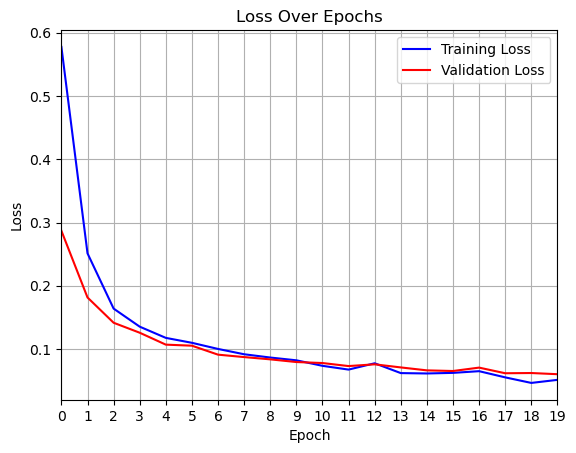

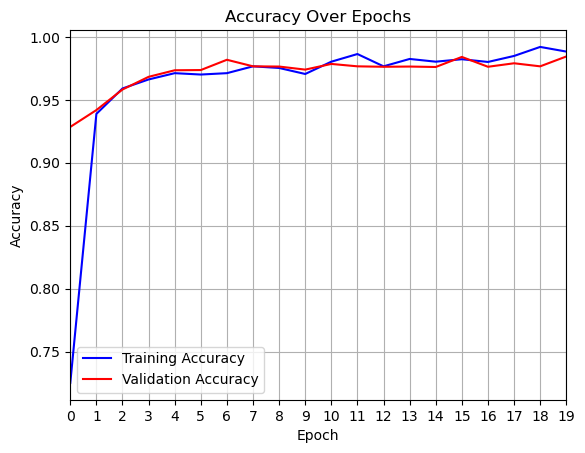

In [46]:
plot_loss_acc(history)

From the graphs, we can see that the training and validation losses are very close to one another, meaning that the model is generalizing well from train to test data. Also note that it only took about 15 min to train for 20 epochs. We'll leave the model unchanged for now

## Save Model

In [112]:
# save the state model of the trained model
torch.save(resnet18_trained.state_dict(), "resnet18_trained.pt")

# Evaluate Model

We'll cycle the model over the test data and see how well the model predicts the test images. Since we're not interested in training in random order, we'll just re-instantiate the test dataset and dataloader

In [47]:
# similar to before, but added an additional normalization
# according to the statistics we calculated

curr_transf = transforms.Compose([transforms.v2.ToDtype(torch.float),
                                  transforms.Normalize([0,0,0],[255,255,255]),
                                  transforms.Resize(size=(IMAGE_SIZE,IMAGE_SIZE)),
                                  transforms.Normalize(mean,std)
                                 ])

In [48]:
test_dataset = CustomFireImagesDataset(annotations_file_test, path_to_dataset,
                                       transform = curr_transf
                                      )

img_classes = ('non-fire','fire')

In [49]:
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = 2)

In [51]:
label_list = []
pred_list = []

for batch in test_dataloader:
    # Get images and labels from batch
    images, true_labels = batch
    
    pred_logits = resnet18_trained(images)

    # Get predicted labels (hard predictions) on images
    # currently the implementation doesn't account for this
    pred_labels = torch.argmax(resnet18_trained(images), dim = 1)

    label_list.extend(list(true_labels.numpy()))
    pred_list.extend(list(pred_labels.numpy()))

In [53]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

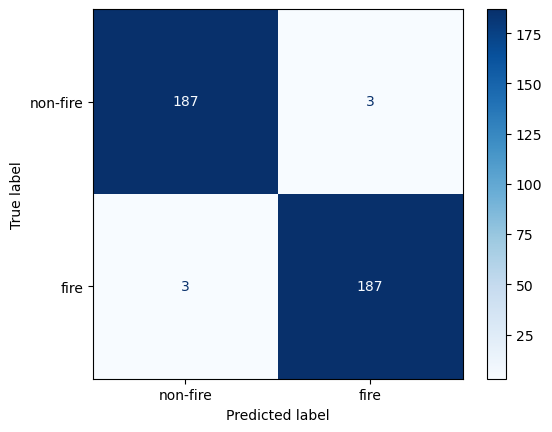

In [102]:
# calculate the confusion matrix 
cm = confusion_matrix(label_list, pred_list)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = img_classes)

fig, ax = plt.subplots()
disp = disp.plot(xticks_rotation='vertical', ax=ax, cmap = 'Blues')
plt.xticks(rotation = 0)
plt.show()

In [55]:
report = classification_report(label_list,pred_list)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       190
           1       0.98      0.98      0.98       190

    accuracy                           0.98       380
   macro avg       0.98      0.98      0.98       380
weighted avg       0.98      0.98      0.98       380



We see that the F1-score of the model is very high. 

Also note there are only 3 false negatives and 3 false positives. This explains why the model had both training and validation losses so similar. 

We'll take a closer look at the instances where there were misclassifications in teh next section.

# Taking a closer look at False Positives and False Negatives

Let's use the annotations file to identify the images that were misclassified

In [65]:
import os
import pandas as pd

annot_file = os.path.join(path_to_dataset,annotations_file_test)
df = pd.read_csv(annot_file, header = None)
df.columns = ['item','label']
df

,item,label
0,./testing/fire/fire_0648.jpg,1
1,./testing/fire/fire_0890.jpg,1
2,./testing/fire/fire_0927.jpg,1
3,./testing/fire/fire_0728.jpg,1
4,./testing/fire/fire_0072.jpg,1
...,...,...
375,./testing/nofire/nofire_0206.jpg,0
376,./testing/nofire/nofire_0400.jpg,0
377,./testing/nofire/nofire_0372.jpg,0
378,./testing/nofire/nofire_0831.jpg,0


Add a new column with the predicted labels.

In [66]:
df['pred_label'] = pred_list

In [67]:
df.head()

,item,label,pred_label
0,./testing/fire/fire_0648.jpg,1,1
1,./testing/fire/fire_0890.jpg,1,1
2,./testing/fire/fire_0927.jpg,1,1
3,./testing/fire/fire_0728.jpg,1,1
4,./testing/fire/fire_0072.jpg,1,1


Find a subset where the predictions don't match the true labels

In [74]:
misc = df.query('label != pred_label')
misc

,item,label,pred_label
54,./testing/fire/fire_0945.jpg,1,0
82,./testing/fire/fire_0348.jpg,1,0
133,./testing/fire/fire_0169.jpg,1,0
199,./testing/nofire/nofire_0762_cropped.jpg,0,1
278,./testing/nofire/nofire_0535.jpg,0,1
370,./testing/nofire/nofire_0938_cropped.jpg,0,1


Next, we'll plot the images.

In [71]:
import matplotlib.pyplot as plt
from src.visualization.plot_images import display_image

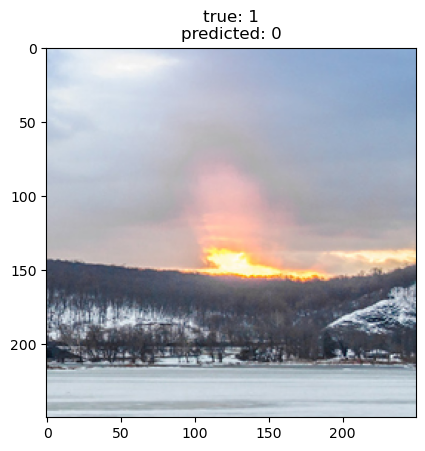

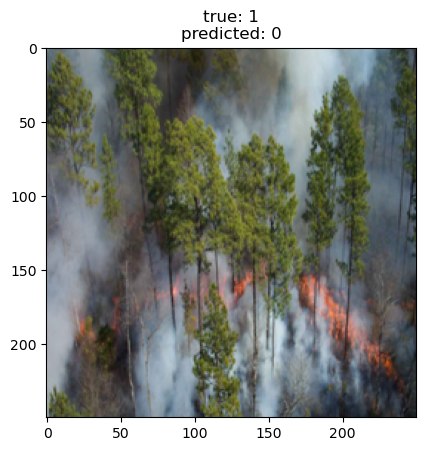

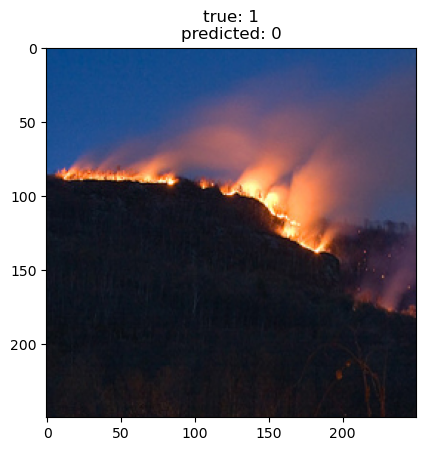

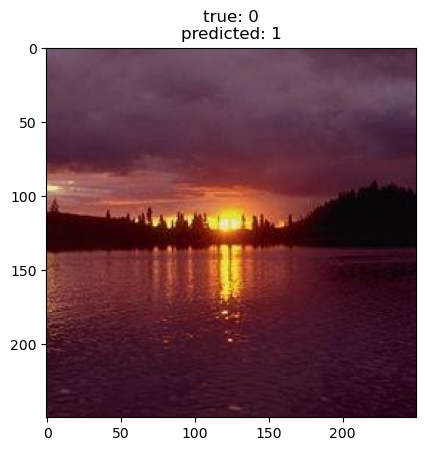

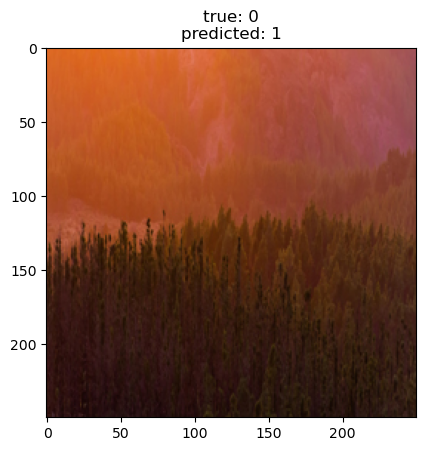

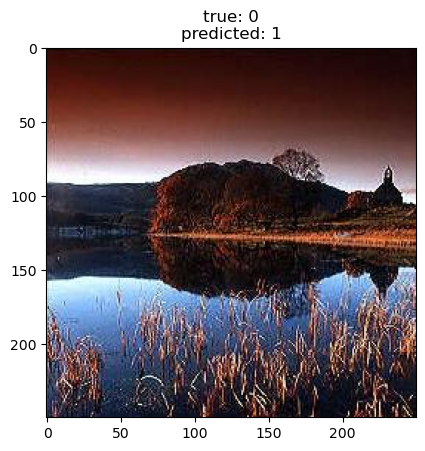

In [98]:
for ind in misc.index:
    true = misc.loc[ind,'label']
    pred = misc.loc[ind,'pred_label']
    
    title_str = f'true: {true}\npredicted: {pred}'

    full_img_path = os.path.join(path_to_dataset,misc.loc[ind,'item'])
    
    display_image(full_img_path,title_str)
    # print(title_str)

It seems the model confused some images with sunsets as images of fires. 

In [99]:
from sklearn.metrics import roc_curve, roc_auc_score

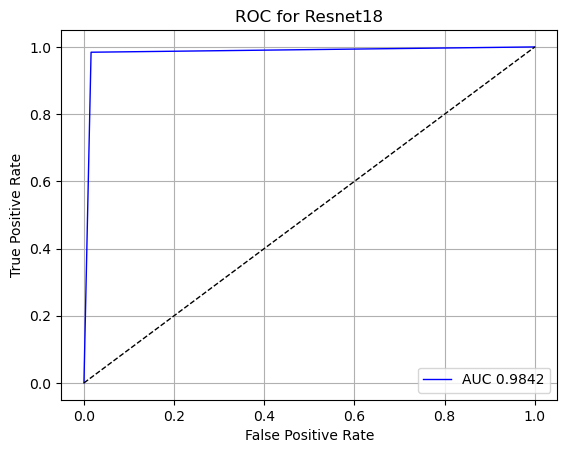

In [113]:
fpr, tpr, _ = roc_curve(label_list,pred_list)
score = roc_auc_score(label_list,pred_list)

plt.figure()
plt.plot(fpr,tpr, color = 'b', lw = 1, label = f'AUC {score:0.4f}')
plt.plot([0, 1], [0, 1], color='k', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.grid()
plt.title('ROC for Resnet18')
plt.legend()
plt.show()

The AUC score of 0.9842 is very close that reported on the reference [publication](https://doi.org/10.1155/2022/5358359), of 0.9889 but this indicates our trained model is doing a very good classification task.

# Conclusion

We've successfuly trained Resnet18 using transfer learning and images of 128 x 128 pixels. 
The AUC score is very close to that from the reference publication.

In a separate notebook, we'll further analyze the nature of the False Positives and False Negatives and compare with ResNet models.

Additionally, we will further abstract some of the model evaluation calculations, to avoid having too much code cluttering the notebook.